In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import warnings

In [2]:
warnings.filterwarnings('ignore')

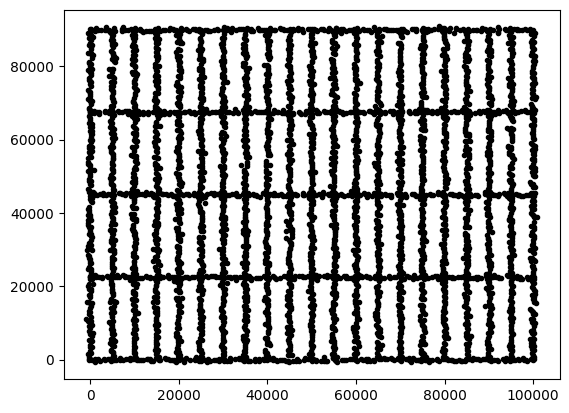

In [10]:
region = [0, 100e3, 0, 90e3]
spacing_1 = (500,5000) 
coordinates_1 = vd.grid_coordinates(region=region, spacing=spacing_1, extra_coords=500) 
spacing_2 = (20000,500)
coordinates_2 = vd.grid_coordinates(region=region, spacing=spacing_2, extra_coords=500) 
#plt.plot(coordinates_1[0],coordinates_1[1], ".k")
#plt.plot(coordinates_2[0],coordinates_2[1], ".k")

coordinates = []
for i in range(0,3):
    coordinates.append(np.concatenate((np.ravel(coordinates_1[i]),np.ravel(coordinates_2[i]))))
#plt.plot(coordinates[0],coordinates[1],".k")

noise_level_coords = 300
coordinates_noise = []
for i in range(0,3):
    if i == 2:
        coordinates_noise.append(coordinates[i] + np.random.default_rng(42).normal(
        0, 10, size=coordinates[i].shape
    ))
    else:
        coordinates_noise.append(coordinates[i] + np.random.default_rng(42).normal(
        0, noise_level_coords, size=coordinates[i].shape
    ))

plt.plot(coordinates_noise[0],coordinates_noise[1],".k")


In [11]:
inclination, declination = -20, -15
base_level = 500
noise_level = 200
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

# Dipoles
dipole_coordinates = (20e3, 15e3, 2e3)
magnetic_field = hm.dipole_magnetic(
    coordinates_noise,
    dipoles=dipole_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(7e10, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))
dipole2_coordinates = (20e3, 80e3, 1e3)
magnetic_field = hm.dipole_magnetic(
    coordinates_noise,
    dipoles=dipole2_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(5e11, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Pipe
size = 70
pipe_coordinates = (60e3, 80e3, 500)
magnetic_field = hm.prism_magnetic(
    coordinates_noise,
    prisms=[
        pipe_coordinates[0] - size,
        pipe_coordinates[0] + size,
        pipe_coordinates[1] - size,
        pipe_coordinates[1] + size,
        pipe_coordinates[2] - 10e3,
        pipe_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(15e3, -90, 0),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Dike
dike_coordinates = (30e3, 30e3, 900)
magnetic_field = hm.prism_magnetic(
    coordinates_noise,
    prisms=[
        dike_coordinates[0] - 100e3,
        dike_coordinates[0] + 100e3,
        dike_coordinates[1] - 100,
        dike_coordinates[1] + 100,
        dike_coordinates[2] - 7e3,
        dike_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(1000, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Line
line_coordinates = [30e3, 50e3, 0]
magnetic_field = hm.prism_magnetic(
    coordinates_noise,
    prisms=[
        line_coordinates[0] - 50,
        line_coordinates[0] + 50,
        line_coordinates[1],
        line_coordinates[1] + 100e3,
        line_coordinates[2] - 50,
        line_coordinates[2] + 50,
    ],
    magnetization=hm.magnetic_angles_to_vec(35e3, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Sill
sill_coordinates = [80e3, 25e3, -0.5e3]
magnetic_field = hm.prism_magnetic(
    coordinates_noise,
    prisms=[
        sill_coordinates[0] - 10e3,
        sill_coordinates[0] + 10e3,
        sill_coordinates[1] - 15e3,
        sill_coordinates[1] + 15e3,
        sill_coordinates[2] - 1000,
        sill_coordinates[2] + 1000,
    ],
    magnetization=hm.magnetic_angles_to_vec(500, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
# Regional
magnetic_anomaly += 0.01 * coordinates_noise[0] - 0.02 * coordinates_noise[1]

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)
magnetic_anomaly += base_level

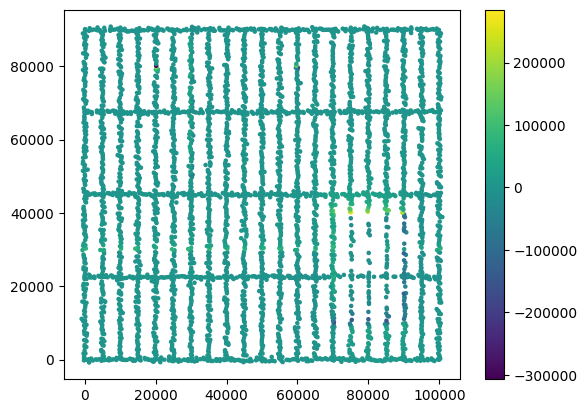

In [12]:
plt.scatter(coordinates_noise[0], coordinates_noise[1], s=5, c=magnetic_anomaly)
plt.colorbar()

In [17]:
# Equivalent sources
# problema é em coordinates_noise
# fonts = hm.EquivalentSourcesGB(damping=1,depth=1e3)
# fonts.fit([coordinates_noise[0],coordinates_noise[1],coordinates_noise[2]],data=magnetic_anomaly)